#### Cargar datos de entrenamiento

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

bright_path = '/kaggle/input/sperm3d-centerlinefromfocalplane/bright_field'
hue_path    = '/kaggle/input/sperm3d-centerlinefromfocalplane/hue_stack'
#value_path  = '/kaggle/input/sperm-z-color-plane-20/DL-Color/value'
centerline_path    = '/kaggle/input/sperm3d-centerlinefromfocalplane/centerline_map'


image_name = sorted(os.listdir(bright_path))

# Splitting the data into train and test sets
train_test_split = 1024+256  # Adjust this as needed
train_name_1 = image_name[:train_test_split]

train_valid_split = 1024
train_name= train_name_1[:train_valid_split]
valid_name = train_name_1[train_valid_split:]

# Construir generadores para el entrenamiento

In [2]:
from skimage import io

def data_generator_seg(filenames, batch_size):
    num_samples = len(filenames)
    while True:
        # Shuffle the indices at the start of each epoch
        indices = np.random.permutation(num_samples)
        
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            #batch_file_pairs = [file_pairs[j] for j in batch_indices]
            batch_inputs = [io.imread(os.path.join(hue_path       , filenames[j])) for j in batch_indices]
            batch_outputs= [io.imread(os.path.join(centerline_path, filenames[j])) for j in batch_indices]
            #
            yield np.array(batch_inputs)/255, np.ceil(np.array(batch_outputs)/255)
            #yield np.array(batch_inputs)/255,np.array(batch_inputs)/255
            

batch_size = 32
train_generator = data_generator_seg(train_name, batch_size)
validation_generator = data_generator_seg(valid_name, batch_size)

(2, 32, 480, 640)


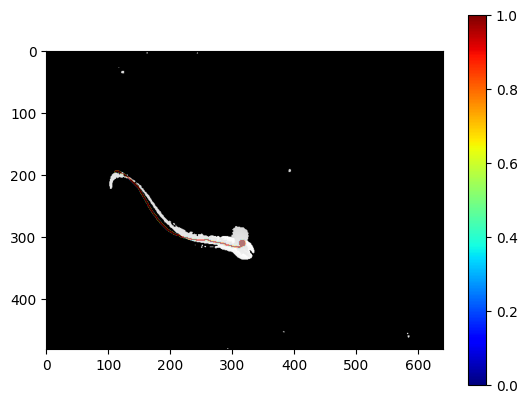

In [3]:
for tr in train_generator:
    print(np.array(tr).shape)
    break
plt.imshow(tr[0][0],cmap="gray")
c=plt.imshow(tr[1][0],cmap="jet",alpha=np.where(tr[1][0]==0,0.0,0.5))
plt.colorbar(c)
plt.show()

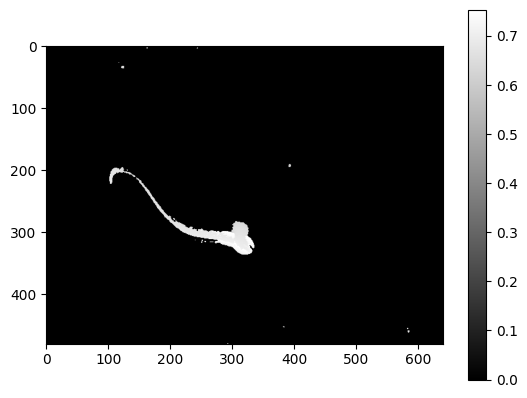

In [4]:

c=plt.imshow(tr[0][0],cmap="gray")
plt.colorbar(c)
plt.show()

In [5]:
print(np.max(tr[1][0]))

1.0


# Construir unet

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage.metrics import structural_similarity as ssim


def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    #x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding="same", activation=tf.keras.layers.LeakyReLU(negative_slope=0.1), kernel_initializer="he_normal")(x)
    #x = layers.Conv2D(n_filters, 3, padding="same", activation=tf.keras.layers.LeakyReLU(negative_slope=0.1), kernel_initializer="he_normal")(x)
    #x = layers.Conv2D(n_filters, 3, padding="same", activation=tf.keras.layers.LeakyReLU(negative_slope=0.1), kernel_initializer="he_normal")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 2, strides=2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

def build_unet_model():
    # inputs
    inputs = layers.Input(shape=(480, 640, 1))

    # encoder: contracting path - downsample
    # 1 - downsample
    n_filters_first = 16
    f1, p1 = downsample_block(inputs, n_filters_first*2)
    # 2 - downsample
    f2, p2 = downsample_block(p1, n_filters_first * 2)
    # 3 - downsample
    f3, p3 = downsample_block(p2, n_filters_first * 4)
    # 3 - downsample
    #f4, p4 = downsample_block(p3, n_filters_first * 8)


    # 5 - bottleneck
    bottleneck = double_conv_block(p3, n_filters_first * 8)

    # decoder: expanding path - upsample
    #u6 = upsample_block(bottleneck, f4, n_filters_first * 8)
    
    # 7 - upsample
    u7 = upsample_block(bottleneck, f3, n_filters_first * 4)
    # 8 - upsample
    u8 = upsample_block(u7, f2, n_filters_first * 2)
    # 9 - upsample
    u9 = upsample_block(u8, f1, n_filters_first)

    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(u9)

    # U-Net model with TensorFlow's Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

unet_model = build_unet_model()

def weighted_bce(ground_truth,y_pred):
    ground_truth = tf.cast(ground_truth,float)
    weights =  ground_truth * 75 + 1.
    bce = K.binary_crossentropy(ground_truth, y_pred)
    weighted_bce = K.mean(bce * weights)
    return weighted_bce

checkpoint_filepath = 'unet2-5.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',  # Change to 'val_loss' to monitor weighted BCE loss
    mode='min',  # Change to 'min' since we are monitoring loss
    save_best_only=True
)


def weighted_mae(y_true, y_pred):
    """
    MAE where non-zero pixels are weighted by 1000, zeros (background) by 1.
    """
    weights = tf.where(tf.not_equal(y_true, 0), 50.0, 1.0)
    error = tf.abs(y_true - y_pred)
    weighted_error = weights * error
    return tf.reduce_mean(weighted_error)

m = tf.keras.metrics.MeanIoU(num_classes=2)

def dice_loss_2D(y_true, y_pred, smooth=1e-7):
    # Ensure both y_true and y_pred are float32
    y_true = tf.cast(y_true, tf.float32)
    #print("Cantidad de ceros en y_true:", tf.reduce_sum(tf.cast(y_true == 0, tf.int32)))

    y_pred = tf.cast(y_pred, tf.float32)

    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    
    dice_loss = 1.0 - dice
    return dice_loss


def dice_2D(y_true, y_pred, smooth=1e-7):
    # Ensure both y_true and y_pred are float32
    y_true = tf.cast(tf.where(y_true==0,0,1), tf.float32)
    y_pred = tf.cast(tf.where(y_pred==0,0,1), tf.float32)
    
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice


def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

# Add the Dice coefficient metric to your model compilation
unet_model.compile(tf.keras.optimizers.Adam(learning_rate=0.0008),
              loss=dice_loss_2D,metrics=["mae"])#tf.keras.losses.BinaryCrossentropy(),
              

unet_model.summary()



2025-04-21 13:50:21.754141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745243421.983818      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745243422.053327      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1745243434.878623      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 480, 640, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 480, 640, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 240, 320, 32)   │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 240, 320, 32)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 240, 320, 32)   │          9,248 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 120, 160, 32)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 120, 160, 32)   │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 120, 160, 64)   │         18,496 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 60, 80, 64)     │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 60, 80, 64)     │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 60, 80, 128)    │         73,856 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 120, 160, 64)   │         32,832 │ conv2d_3[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 120, 160, 128)  │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 120, 160, 128)  │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 120, 160, 64)   │         73,792 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 240, 320, 32)   │          8,224 │ conv2d_4[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1        

 Total params: 244,241 (954.07 KB)

 Trainable params: 244,241 (954.07 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Start the timer
import time
import tensorflow.keras.backend as K

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau


# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='loss',  # Monitor validation loss
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best-performing model
)


# Define the ReduceLROnPlateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='loss',
    factor=0.1,  # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=5,  # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1  # Print a message when the learning rate is reduced
)

start_time = time.time()

# Train the model
history=unet_model.fit(
    train_generator,
    steps_per_epoch=int(np.floor(len(train_name) / batch_size)),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=int(np.floor(len(valid_name) / batch_size)),
    callbacks=[model_checkpoint_callback,early_stopping_callback]#,reduce_lr_callback]
)

# Calculate the training time
training_time = time.time() - start_time

# Print the training time
print("Training time:", training_time/60, "min")

Epoch 1/50


I0000 00:00:1745243442.976613      92 service.cc:148] XLA service 0x7cf68c40b2a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745243442.977482      92 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745243443.462268      92 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-21 13:50:54.127865: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,16,480,640]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,48,480,640]{3,2,1,0}, f32[16,48,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-04-21 13:50:54.7

32/32 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - loss: 0.9927 - mae: 0.5198 - val_loss: 0.9885 - val_mae: 0.5086
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 497ms/step - loss: 0.9885 - mae: 0.5006 - val_loss: 0.9040 - val_mae: 0.0431
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 481ms/step - loss: 0.8684 - mae: 0.0206 - val_loss: 0.8510 - val_mae: 0.0110
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 479ms/step - loss: 0.7798 - mae: 0.0057 - val_loss: 0.8494 - val_mae: 0.0091
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 475ms/step - loss: 0.7711 - mae: 0.0060 - val_loss: 0.8526 - val_mae: 0.0068
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 475ms/step - loss: 0.7634 - mae: 0.0062 - val_loss: 0.8486 - val_mae: 0.0065
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 470ms/step - loss: 0.7593 - mae: 0.0059 - val_loss: 0.8450 - val_mae: 0.0065
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 468ms/step - loss: 0.7520 - mae: 0.0060 - val_loss: 0.8352 - val_mae: 0.0066
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 478ms/step - loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step


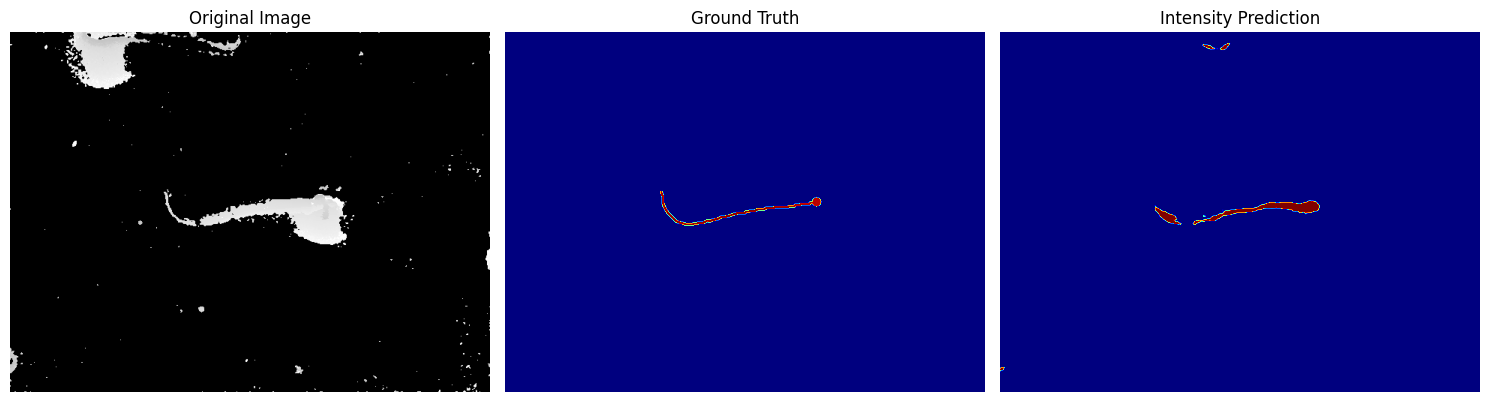

In [8]:

# Load your single image
source_img = io.imread(os.path.join(hue_path, image_name[20]))/255
target_img = io.imread(os.path.join(centerline_path, image_name[20]))/255


#source_img = io.imread(os.path.join(bright_path, image_name[20]))/255
#target_img = io.imread(os.path.join(hue_path, image_name[20]))/255
#if len(source_img.shape) == 2:
#    source_img = source_img[..., np.newaxis]


# Create a batch
batch_x = np.array([source_img], dtype=np.float32)
batch_y = np.array([target_img], dtype=np.float32)


# Preprocess the input image and ground truth mask


# Generate prediction
prediction = unet_model.predict(batch_x)

# Expand dimensions for prediction

# Plot the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Original Image
axs[0].imshow(batch_x[0], cmap="gray")
axs[0].set_title("Original Image")
#plt.colorbar(plt.cm.ScalarMappable(cmap="gray"), ax=axs[0], orientation='vertical')
axs[0].axis("off")

# Ground Truth
axs[1].imshow(batch_y[0], cmap="jet")
axs[1].set_title("Ground Truth")
#plt.colorbar(plt.cm.ScalarMappable(cmap="gray"), ax=axs[1], orientation='vertical')

axs[1].axis("off")

# Prediction
#print(prediction[0])
pred=prediction[0][5]=0
axs[2].imshow(prediction[0], cmap="jet")
axs[2].set_title("Intensity Prediction")
#plt.colorbar(plt.cm.ScalarMappable(cmap="gray"), ax=axs[2], orientation='vertical')
axs[2].axis("off")
#print(prediction[0])

plt.tight_layout()
plt.show()



In [9]:
# Optionally, save the metrics DataFrame to a CSV file
metrics_df.to_csv('training_metrics.csv', index=False)
metrics_df

NameError: name 'metrics_df' is not defined